# Wissensbasierte Systeme 
## ML-Übung #1 "Nächste Nachbarn" und "Random Forest"

**Dozenten:** Dr. Sina Keller, M.sc. Felix Riese

**Datum:** 22.11.2017

**Datensatz:** EnMAP-Contest, [Download der Daten](http://www2.ipf.kit.edu/Projekte/code/EnMAP_Contest.zip) mit [Beschreibung](https://www.ipf.kit.edu/downloads/Instructions_EnMAP_Contest.pdf)

In [201]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd

### 1. Einlesen des Datensatzes
Der Datensatz `EnMAP_Contest_Data.mat` wurde heruntergeladen in das Verzeichnis dieses Notebooks.

In [202]:
datadict = {}
with h5py.File("./EnMAP_Contest_Data.mat", 'r') as f:
    for k, v in f.items():
        datadict[k] = np.array(v)

print(datadict.keys())

dict_keys(['Im', 'cm', 'lx', 'ly', 'xi', 'yi'])


### 2. Überblick über den Datensatz erhalten

##### Größe des Datensatzes und Anzahl möglicher Klassen herausfinden

In [203]:
print("{var:<8} | {shape:^15}".format(var="Variable", shape="Shape"))
print("-"*27)
for key in datadict.keys():
    print("{var:<8} | {shape:<15}".format(var=key, shape=str(datadict[key].shape)))

Variable |      Shape     
---------------------------
Im       | (244, 1000000) 
cm       | (3, 21)        
lx       | (1, 2617)      
ly       | (1, 1124)      
xi       | (244, 2617)    
yi       | (244, 1124)    


`Im`: Image data (244 Schichten, 1000 * 1000 Pixel)

`cm`: color map ( R-G-B für 21 Klassen )

`lx`: training_labels (2617 Labels für die jeweiligen Trainingsdaten)

`ly`: evaluation_labels (1124 Labels für die jeweiligen Evaluationsdaten)

`xi`: training_data (2617 Datensätze mit jeweils einem Pixel aus 244 Schichten)

`yi`: evaluation_data (1124 Datensätze mit jeweils einem Pixel aus 244 Schichten)

`x`: Training, y: Evaluation

##### Ein paar Zeilen (= Datenpunkte) anschauen mit `.head(5)` und `.tail(5)`

Erste 5 Bild-Zeilen

In [204]:
pd.DataFrame(data=datadict["Im"][0:,0:]).T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,234,235,236,237,238,239,240,241,242,243
0,0.241830,0.265971,0.293590,0.327478,0.336228,0.368227,0.372861,0.388350,0.393245,0.412679,...,0.513941,0.510366,0.520273,0.519186,0.533459,0.523864,0.485793,0.508475,0.522124,0.500204
1,0.416993,0.448501,0.456410,0.496863,0.497519,0.528325,0.540342,0.549757,0.582630,0.580144,...,0.240769,0.232567,0.254263,0.242134,0.238563,0.233677,0.225335,0.221953,0.230088,0.217232
2,0.313725,0.303781,0.366667,0.362610,0.385856,0.396552,0.426650,0.436893,0.453559,0.458134,...,0.238885,0.233321,0.214096,0.224482,0.226087,0.213440,0.206393,0.171106,0.200724,0.230706
3,0.202614,0.237288,0.239744,0.267252,0.258065,0.275862,0.309291,0.316748,0.314837,0.322967,...,0.204974,0.196758,0.197423,0.194935,0.190926,0.174876,0.167324,0.176755,0.173371,0.145774
4,0.125490,0.178618,0.161538,0.199498,0.214640,0.236453,0.238386,0.254854,0.253317,0.248804,...,0.186888,0.180927,0.192497,0.176899,0.177694,0.180221,0.152328,0.184019,0.168544,0.153532


RGB-Werte für die Klassen

In [205]:
pd.DataFrame(data=datadict["cm"].T, columns=["R","G","B"]).head(21)

,R,G,B
0,0.000000,0.000000,0.156863
1,0.007843,0.000000,0.478431
2,0.011765,0.000000,0.929412
3,0.427451,0.411765,1.000000
4,0.000000,0.258824,0.207843
5,0.003922,0.278431,0.000000
6,0.000000,0.725490,0.000000
7,0.074510,1.000000,0.074510
8,0.756863,0.039216,0.000000
9,0.133333,0.215686,0.000000


In [206]:
print(datadict["cm"].T[0])

[ 0.          0.          0.15686275]


Erste 10 Trainingsdatensätze mit zugehörigem Klassen-Label

In [207]:
datasets_with_labels = np.vstack([datadict["lx"], datadict["xi"][0:,0:]]).T
pd.DataFrame(data=datasets_with_labels).head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,1.0,0.037908,0.046936,0.044872,0.036386,0.050868,0.046798,0.039120,0.040049,0.042220,...,0.009420,0.006785,0.006063,0.004221,0.016635,0.027873,0.033938,0.002825,0.023733,0.000000
1,1.0,0.058824,0.029987,0.050000,0.037641,0.034739,0.034483,0.029340,0.046117,0.031363,...,0.003768,0.008669,0.021220,0.004605,0.014745,0.013364,0.000000,0.004036,0.032180,0.034300
2,1.0,0.052288,0.040417,0.041026,0.040151,0.052109,0.062808,0.053790,0.052184,0.072376,...,0.011304,0.028270,0.012126,0.011128,0.006427,0.012218,0.000000,0.013721,0.003620,0.024500
3,1.0,0.060131,0.080834,0.064103,0.060226,0.050868,0.060345,0.079462,0.060680,0.060314,...,0.013564,0.000000,0.007579,0.000000,0.000000,0.025582,0.004341,0.000000,0.029767,0.043283
4,1.0,0.048366,0.061278,0.060256,0.062735,0.043424,0.055419,0.055012,0.044903,0.045838,...,0.000000,0.013570,0.014020,0.024942,0.000378,0.029401,0.016180,0.012107,0.026951,0.024908
5,1.0,0.077124,0.066493,0.055128,0.031368,0.055831,0.046798,0.056235,0.057039,0.054282,...,0.003391,0.000377,0.000000,0.000000,0.015501,0.002291,0.023678,0.023002,0.004827,0.025725
6,1.0,0.056209,0.039113,0.055128,0.048934,0.018610,0.036946,0.030562,0.023058,0.030157,...,0.000377,0.000000,0.012884,0.000000,0.010964,0.021764,0.006314,0.014931,0.037812,0.028583
7,1.0,0.039216,0.079531,0.047436,0.052698,0.057072,0.060345,0.062347,0.042476,0.063932,...,0.006029,0.013570,0.020841,0.001919,0.006049,0.003436,0.003946,0.005246,0.000000,0.002042
8,1.0,0.056209,0.057366,0.041026,0.052698,0.016129,0.040640,0.046455,0.057039,0.068758,...,0.013941,0.008669,0.011747,0.011896,0.000000,0.030164,0.011050,0.013721,0.006034,0.014292
9,1.0,0.070588,0.053455,0.047436,0.074028,0.057072,0.055419,0.055012,0.054612,0.057901,...,0.000000,0.024501,0.003410,0.002686,0.003025,0.046583,0.013023,0.000000,0.003620,0.007758


##### Datensatz geeignet visualisieren in mehreren Plots

Ein Trainingsdatensatz in einen Graph geplottet

Trainingsdatensatz 5:


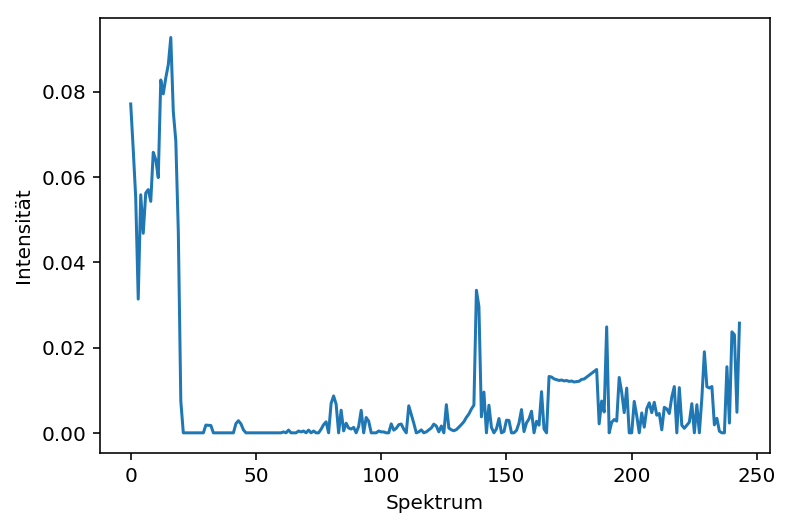

In [208]:
dataset_number = 5
plt.plot(datadict["xi"].T[dataset_number])
plt.xlabel("Spektrum")
plt.ylabel("Intensität")
print("Trainingsdatensatz %i:" % dataset_number)

Alle Trainingsdatensätze einer Klasse in einen Graph geplottet

Klasse 9 gehören 140 Trainingsdatensätze an:


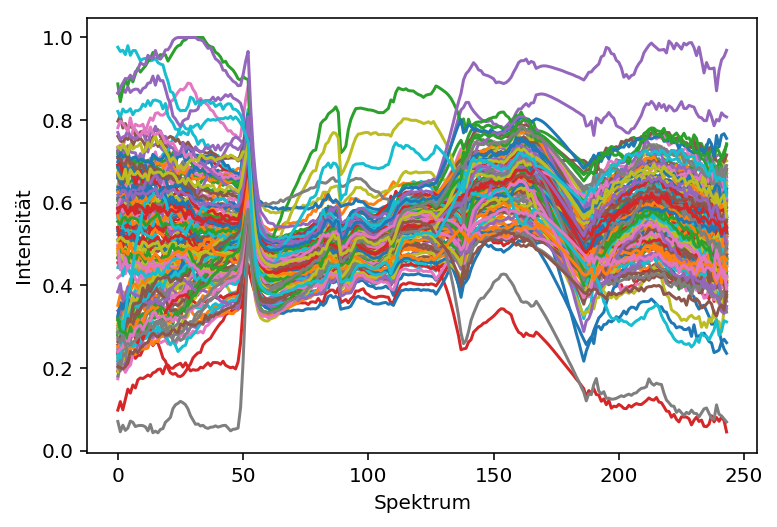

In [209]:
class_number = 9
class_member_amount = 0
for dataset in datasets_with_labels:
    if dataset[0] == class_number:
        class_member_amount += 1
        plt.plot(dataset[1:])
plt.xlabel("Spektrum")
plt.ylabel("Intensität")
print("Klasse %i gehören %i Trainingsdatensätze an:" % (class_number, class_member_amount))

##### Karte `Im` geeignet visualisieren mit entsprechender Klasse

### 3. Vorprozessierung implementieren

##### Reduzierung der Bänder (z.B. Zusammenfassen von Bändern)

##### Glättung (Filterung) der Spektren

##### Möglicherweise schon Dimensionsreduzierung implementieren

### 4. Datensatz splitten in Trainings- und Testdatensatz

Schon gemacht:
- `xi`, `lx` Gelabelte Testdaten
- `yi`, `ly` Gelabelte Validierungsdaten

### 5. Klassifikatoren implementieren und testen

In [210]:
import sklearn.ensemble
import sklearn.neighbors
import sklearn.neural_network

#### Random Forest (ada-boost)

In [211]:
forest = sklearn.ensemble.RandomForestClassifier(
    n_estimators=30, # Standard ist 10, höhere Werte bis 30 besser, darüber ohne Unterschied
    max_features=None, # "log2" beste Methode
    # max_depth=None, (Standard ist das beste)
    # min_samples_split = 2, (Standard ist das beste)
    oob_score = True,
    # bootstrap=True, (Standard ist das beste)
)
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
print(datadict["xi"].T.shape)
print(datadict["lx"].T.ravel().shape)
forest.fit(datadict["xi"].T, datadict["lx"].T.ravel())
forest.score(datadict["yi"].T, datadict["ly"].T.ravel())

(2617, 244)
(2617,)


0.83451957295373669

#### Nächster Nachbar / k nearest neighbors (KNN)

In [212]:
knn = sklearn.neighbors.KNeighborsClassifier(
    n_neighbors=13,
    weights='uniform', #'distance' für p=2 besser als 'uniform'
#     algorithm='brute', # macht keinen Unteschied
    p=3 #besser als p=2 (Standard)
)
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
print(datadict["xi"].T.shape)
print(datadict["lx"].T.ravel().shape)
knn.fit(datadict["xi"].T, datadict["lx"].T.ravel())
knn.score(datadict["yi"].T, datadict["ly"].T.ravel())

(2617, 244)
(2617,)


0.83096085409252674

#### Multi Layer Perceptrons (MLP)

In [213]:
mlp = sklearn.neural_network.MLPClassifier()
# http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
print(datadict["xi"].T.shape)
print(datadict["lx"].T.ravel().shape)
mlp.fit(datadict["xi"].T, datadict["lx"].T.ravel())
mlp.score(datadict["yi"].T, datadict["ly"].T.ravel())

(2617, 244)
(2617,)


0.78825622775800708

#### Voting Classifier

In [214]:
mlp = sklearn.ensemble.VotingClassifier(estimators=[('forest', forest), ('knn', knn)], voting='soft')

# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
print(datadict["xi"].T.shape)
print(datadict["lx"].T.ravel().shape)
mlp.fit(datadict["xi"].T, datadict["lx"].T.ravel())
mlp.score(datadict["yi"].T, datadict["ly"].T.ravel())

(2617, 244)
(2617,)


0.83185053380782914